# Differential Intelligence

(original by Dario Izzo - extended by Ekin Ozturk)

In this notebook we lay down the basic idea behind “differential intelligence”, that is the use of high order derivatives in machine learning using desolver as the numerical integration engine.

We show the use of quadruple precision arithmetic for computing the numerical integration.

(`gdual_real128` is not available on every platform, consult the PyAudi documentation [here](https://darioizzo.github.io/audi/))

## Importing Stuff

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np

os.environ['DES_BACKEND'] = 'numpy'
import desolver as de
import desolver.backend as D

D.set_float_fmt('gdual_real128')

PyAudi backend is available.
Using numpy backend


## Controller representation and “simulator”

Take as an example the task of learning a robotic controller. In neuro evolution (or Evolutionary Robotics), the controller is typically represented by a neural network, but for the purpose of explaining this new learning concept we will use a polinomial representation for the controller. Later, changing the controller into a NN with weights as parameters will not change the essence of what is done here.

In [2]:
# Definition of the controller in terms of some weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [3]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## Numerical Integration - Runge-Kutta 8(7) Dormand-Prince Method

In Evolutionary Robotics, Euler propagators are commonly used, but we would like to use a higher order integration scheme that is adaptive in order to minimise computation, and increase the accuracy and precision of the results.

In [4]:
weights = D.array([D.gdual_real128(0.05*(np.random.uniform()-0.5), _, 4) for _ in "abcefg"])
x = [D.gdual_real128(2*(np.random.uniform()-0.5))]
v = [D.gdual_real128(2*(np.random.uniform()-0.5))]
y0 = D.array(x + v, dtype=D.gdual_real128)

In [5]:
def rhs(t, state, weights, **kwargs):
    return D.array(eom(state, weights))

We integrate the system using the Runge-Kutta 8(7) scheme[1] as the numerical integration system with a dense output computed using a piecewise C1 Hermite interpolating spline. 

This particular interpolator is used as it satisfies not only the state boundary conditions, but also the gradients and is well suited for approximating the solution continuously up to first order in time.

Note that the entire integration is done using gduals and thus the solution and the interpolating spline stored in the OdeSystem instance, `pyaudi_integration`, contains all the information about how the state reached by our robot changes when we change the control weights.

[1] Prince, P.J., and J.R. Dormand. ‘High Order Embedded Runge-Kutta Formulae’. Journal of Computational and Applied Mathematics 7, no. 1 (March 1981): 67–75. https://doi.org/10.1016/0771-050X(81)90010-3.

In [6]:
pyaudi_integration = de.OdeSystem(rhs, y0=y0, dense_output=False, t=(0, 10.), dt=0.1, rtol=1e-16, atol=1e-16, constants=dict(weights=weights))

pyaudi_integration.set_method("RK87")
pyaudi_integration.integrate(eta=True)

In [7]:
pyaudi_integration

   message: Integration completed successfully.                                                                                             
      nfev: 1092                                                                                                                            
       sol: None                                                                                                                            
         t: [0.0 0.1 0.21110211576003218 0.3291546927360557 0.4510514133469616
 0.5755104815145154 0.7023885665302934 0.8321584732698275
 0.9658493184498718 1.1055174244410857 1.2565585380390105
 1.4250667942539263 1.575560576264976 1.7161831742912568
 1.8511732923146769 1.9820793056272679 2.109875637642308
 2.2352076864790114 2.3585521059766297 2.480283374243199 2.600712269600027
 2.7201090420483265 2.8387190453306297 2.95677440469424 3.0745038701081264
 3.1921423870517 3.3099418476048954 3.428184907682013 3.5472049442052005
 3.667418041328259 3.7893798850153035 3.91390

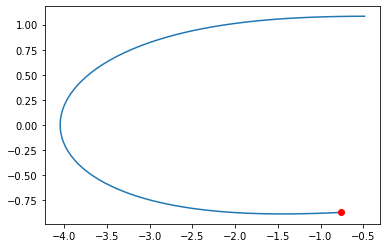

In [8]:
x,v = pyaudi_integration.y.T
plt.plot([it for it in x.astype(np.float64)],[it for it in v.astype(np.float64)])
plt.plot(x.astype(np.float64)[0], v.astype(np.float64)[0], 'ro')
plt.show()

In [9]:
xf, vf = x[-1], v[-1]

In [10]:
print("initial xf: {}".format(xf.constant_cf))
print("initial vf: {}".format(vf.constant_cf))

initial xf: -4.84469824080385238346862703291443047e-01
initial vf: 1.08292462328601443590607267851965142e+00


## Studying the effects of the weights on the behavior

We have represented all the robot behavior (x, v) as a polynomial function of the weights. So we now know what happens to the behaviour if we change the weights!! Lets see … we only consider the final state, but the same can be done for all states before.

In [11]:
dweights = dict({'da': -0.0002, 'db': 0.0003, 'dc': -0.002, 'de': 0.003, 'df': 0.002, 'dg': -0.001})
#Lets predict the new final position of our 'robot' if we change his controller as defined above
print("new xf: {}".format(xf.evaluate(dweights)))
print("new vf: {}".format(vf.evaluate(dweights)))

new xf: -2.49029369142458029767519759429327160e-01
new vf: 1.02675024857857281447237904566368237e+00


## Check that we learned the correct map

We now simulate again our behavior using the new weights to see where we end up to check if the prediction made after our differential learning is correct.

In [12]:
new_weights = np.array([it + dweights['d' + it.symbol_set[0]] for it in weights])

In [13]:
pyaudi_integration2 = de.OdeSystem(rhs, y0=y0, dense_output=True, t=(0, 10.), dt=0.01, rtol=1e-16, atol=1e-16, constants=dict(weights=new_weights))

pyaudi_integration2.set_method("RK87")
pyaudi_integration2.integrate(eta=True)

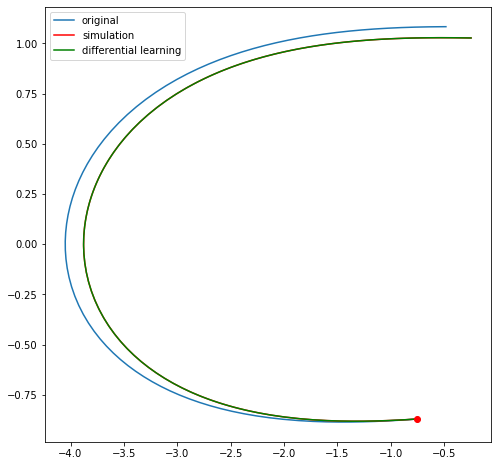

In [14]:
plt.figure(figsize=(8,8))
x2, v2 = pyaudi_integration2.y.T
plt.plot([it for it in x.astype(np.float64)],[it for it in v.astype(np.float64)],label='original')
plt.plot([it for it in x2.astype(np.float64)],[it for it in v2.astype(np.float64)],'r',label='simulation')
plt.plot([float(str(it.evaluate(dweights))) for it in x],[float(str(it.evaluate(dweights))) for it in v],'g',label='differential learning')
plt.plot(x.astype(np.float64)[0], v.astype(np.float64)[0], 'ro')
plt.legend(loc=2)
plt.show()

In [15]:
print("Differential learning xf: \t{}".format(x[-1].evaluate(dweights)))
print("Real xf: \t\t\t{}".format(x2[-1].constant_cf))
print("Mean Absolute Difference xf:\t{}".format(x2[-1].constant_cf - x[-1].evaluate(dweights)))
print()
print("Differential learning vf: \t{}".format(v[-1].evaluate(dweights)))
print("Real vf: \t\t\t{}".format(v2[-1].constant_cf))
print("Mean Absolute Difference vf:\t{}".format(v2[-1].constant_cf - v[-1].evaluate(dweights)))

Differential learning xf: 	-2.49029369142458029767519759429327160e-01
Real xf: 			-2.49007803143589808824139459419541238e-01
Mean Absolute Difference xf:	2.15659988682209433803000097859217757e-05

Differential learning vf: 	1.02675024857857281447237904566368237e+00
Real vf: 			1.02675419219899287968985895151207006e+00
Mean Absolute Difference vf:	3.94362042006521747990584838769166664e-06


In [16]:
pyaudi_integration3 = de.OdeSystem(rhs, y0=y0, dense_output=True, t=(0, 10.), dt=0.01, rtol=1e-16, atol=1e-16, constants=dict(weights=new_weights))

pyaudi_integration3.set_method("RK45")
pyaudi_integration3.integrate(eta=True)

x3, v3 = pyaudi_integration3.y.T

In [17]:
print("Difference between RK45 and RK87 xf: \t{}".format((x2[-1] - x3[-1]).constant_cf))
print("Difference between RK45 and RK87 vf: \t{}".format((v2[-1] - v3[-1]).constant_cf))
print()
print("Mean Absolute Difference xf[RK87]:\t{}".format(x2[-1].constant_cf - x[-1].evaluate(dweights)))
print("Mean Absolute Difference xf[RK45]:\t{}".format(x3[-1].constant_cf - x[-1].evaluate(dweights)))
print()
print("Mean Absolute Difference vf[RK87]:\t{}".format(v2[-1].constant_cf - v[-1].evaluate(dweights)))
print("Mean Absolute Difference vf[RK45]:\t{}".format(v3[-1].constant_cf - v[-1].evaluate(dweights)))

Difference between RK45 and RK87 xf: 	-7.63455303739631190745547176975614994e-16
Difference between RK45 and RK87 vf: 	-1.37172146524820938516857861466601919e-15

Mean Absolute Difference xf[RK87]:	2.15659988682209433803000097859217757e-05
Mean Absolute Difference xf[RK45]:	2.15659988689843986840396409766673229e-05

Mean Absolute Difference vf[RK87]:	3.94362042006521747990584838769166664e-06
Mean Absolute Difference vf[RK45]:	3.94362042143693894515405777286024525e-06
